##### Sprintの目的
- スクラッチを通してSVMを理解する
- 線形モデルと異なる手法に触れる

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。

[サポートベクターマシン(SVM)とは？〜基本からPython実装まで〜](https://kenyu-life.com/2019/02/11/support_vector_machine/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from decimal import Decimal, ROUND_HALF_UP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
#シンプルデータセット1

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [3]:
np.set_printoptions(threshold=0) # nparrayの省略表示
display(X)
display(X.shape)
display(y)
display(y.shape)

array([[ 0.77238275, -2.29167329],
       [-0.59334945,  1.66788336],
       [-2.0764856 ,  0.48746845],
       ...,
       [ 0.31731679,  2.22551981],
       [-1.35919625,  0.89205189],
       [ 1.10298263, -0.54852515]])

(500, 2)

array([-1,  1,  1, ...,  1,  1, -1])

(500,)

In [4]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.lag_lam :  次の形のndarray, shape(n_samples, )
      ラグランジュ乗数
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        #yの値を-1, 1へ置換
        y_replace = self._y_change(y)
        
        #ラグランジュ乗数の初期値設定
        self.lag_lam = np.random.rand(X.shape[0])
        
        #学習
        self.n_support_vectors_list = []
        
        for i in range(self.iter):
            #ラグランジュ未定乗数を最急降下にて更新
            self.lag_lam = self._lagrange_grad_descent(X, y_replace)
            #サポートベクターを決定して、情報を各変数に格納
            self.index_support_vectors = np.where(self.lag_lam > self.threshold)[0]
            self.n_support_vectors = len(self.index_support_vectors)
            self.n_support_vectors_list.append(self.n_support_vectors)
            self.lam_sv = self.lag_lam[self.index_support_vectors]
            self.X_sv = X[self.index_support_vectors]
            self.y_sv = y_replace[self.index_support_vectors]
        
        if self.verbose:
        #verboseをTrueにした際は学習過程を出力
            print("サポートベクター数の過程：\n{}".format(self.n_support_vectors_list))

    
    #問題3
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # f(x)の計算
        fx = np.sum(self.lam_sv.T*self.y_sv.T*self._kernel_func(X, self.X_sv), axis=1)
        # 値を1or-1に置換
        fx = np.where(fx >= 0, 1, -1)
        # 値をもとのラベルへ置換
        fx = np.where(fx == fx.max(), self.y_max, self.y_min)
        
        return fx
    
    #問題1
    def _lagrange_grad_descent(self, X, y):
        """
        ラグランジュ未定乗数を最急降下にて更新する関数
        _kernal_func未使用
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        y：次の形のndarray, shape (n_samples, )
        
        Returns
        new_lam：次の形のndarray, shape(n_samples, 1)
        ----------
        
        """   
        new_lam = self.lag_lam + self.lr*(1 - np.dot(self._kernel_func(X, X), y*self.lag_lam) * y)
        #0未満のラムダの値を0に置換
        new_lam = np.where(new_lam < 0, 0, new_lam)
        
        return new_lam
    
    
    #問題1
    def _kernel_func(self, X1, X2):
        """
        カーネル関数による計算結果

        Parameters
        ----------
        X1 : 次の形のndarray, shape (n_samples1, n_features1)
          サンプル
        X2 : 次の形のndarray, shape (n_samples2, n_features2)
          サンプル       

        Returns
        -------
        k_x : 次の形のndarray, shape (n_samples1, n_features2)
            カーネル関数の計算結果の行列
        """
        if self.kernel == "linear":
            k_x = X1@X2.T
        elif self.kernel == 'polly':
            k_x = (self.p_gamma*(X1@X2.T) + self.p_theta)**self.p_d
        else:
            raise ValueError

        return k_x
    
    def _y_change(self, y):
        """
        yの値を-1, 1へ置換する関数
        """
        self.y_max = y.max()
        self.y_min = y.min()
        y_replace = np.where(y == self.y_max, 1, -1)
        return y_replace

### 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
 
 $$
 λ_i^{new} = λ_i + α(1 - \sum_{i=1}^{n}λ_jy_iy_jk(x_i, x_j))
 $$

ここで$k(x_i, x_j)$はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(x_i, x_j) = x_i^Tx_j
$$

条件として、更新毎に 
$λ_i >= 0$を満たす必要があります。満たさない場合は $λ_i=0$とします。

i, j：サンプルのインデックス

$λ_i^{new}$：更新後のi番目のサンプルのラグランジュ乗数

$ λ_i$：更新前のi番目のサンプルのラグランジュ乗数

α：学習率

$λ_j$：j番目のサンプルのラグランジュ乗数

$y_i$：i番目のサンプルのラベル

$y_j$：j番目のサンプルのラベル

$x_i$：i番目のサンプルの特徴量ベクトル

$x_j$： j番目のサンプルの特徴量ベクトル

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

In [5]:
#確認用
def kernel_func(X1, X2):
    """
    カーネル関数による計算結果

    Parameters
    ----------
    X1 : 次の形のndarray, shape (n_samples1, n_features1)
      サンプル
    X2 : 次の形のndarray, shape (n_samples2, n_features2)
      サンプル       

    Returns
    -------
    k_x : 次の形のndarray, shape (n_samples1, n_features2)
        カーネル関数の計算結果の行列
    """
    k_x = X1@X2.T
    return k_x

In [6]:
#確認用
def lagrange_grad_descent(X, y):
    """
    ラグランジュ未定乗数を最急降下にて更新する関数
    _kernal_func未使用

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル
    y：次の形のndarray, shape (n_samples, )

    Returns
    new_lam：次の形のndarray, shape(n_samples, 1)
    ----------

    """   
    new_lam = lag_lam + 0.001*(1 - np.dot(kernel_func(X, X), y*lag_lam) * y)
    #0未満のラムダの値を0に置換
    new_lam = np.where(new_lam < 0, 0, new_lam)

    return new_lam

In [7]:
def y_change(y):
    """
    yの値を-1, 1へ置換する関数
    """
    y_max = y.max()
    y_min = y.min()
    y_replace = np.where(y == y_max, 1, -1)
    return y_replace

### 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。



In [8]:
#参考（未使用）
def _support_vector(self, X, y):
    """
    サポートベクターを決定して、情報を各変数に格納する関数
    """
    self.n_support_vectors_list = []
    self.X_sv_list = []
    self.lam_sv_list = []

    self.index_support_vectors = np.where(self.lag_lam > self.threshold)[0] #サポートベクターのインデックス。閾値より大きいラグランジュ乗数のインデント 取得
    self.n_support_vectors = len(self.index_support_vectors) #サポートベクターの数
    self.n_support_vectors_list.append(self.n_support_vectors)
    self.X_sv = X[self.index_support_vectors] #サポートベクター(の特徴量)
    self.X_sv_list.append(self.X_sv)
    self.lam_sv = self.lag_lam[self.index_support_vectors]#サポートベクターの未定乗数
    self.lam_sv_list.append(self.lam_sv) 
    self.y_sv = y[self.index_support_vectors]#サポートベクターのラベル

### 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた$f(x)$の符号が分類結果です。

$$
f(x) = \sum_{n=1}^{N}λ_ny_{sv_n}k(x, s_n)
$$

x : 推定したいデータの特徴量ベクトル

N : サポートベクターの数

n : サポートベクターのインデックス

$λ_n$: n番目のサポートベクターのラグランジュ乗数

$y_{sv_n}$: n番目のサポートベクターのラベル

k(): カーネル関数

$s_n$: n番目のサポートベクターの特徴量

### 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def result_each_method(model):
    """
    モデルを入力すると、
    ・そのモデルの指標値
    ・そのモデルの混同行列
    を作成する関数
    
    Parameter
    ---------
    model：モデル 
    """
    
    instance = model 
    model.fit(X_train, y_train)
    print("accuracy:{}".format(accuracy_score(y_test, instance.predict(X_test))))
    print("---------------------")
    print("precision:{}".format(precision_score(y_test, instance.predict(X_test))))
    print("---------------------")
    print("recall:{}".format(recall_score(y_test, instance.predict(X_test))))
    print("---------------------")
    print("f1:{}".format(f1_score(y_test, instance.predict(X_test))))
    print("---------------------")
    print(confusion_matrix(y_test, instance.predict(X_test)))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**ScratchSVMClassifierモデルでの動作確認**

In [19]:
clf = ScratchSVMClassifier(num_iter=500, lr=0.001, verbose=True)
result_each_method(clf)
print("予測値：", clf.predict(X_test))
print("正解値：", y_test)

サポートベクター数の過程：
[41, 39, 34, 32, 32, 31, 31, 29, 28, 28, 26, 25, 24, 20, 20, 19, 18, 18, 18, 17, 17, 16, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

**scikit-learnのSVCモデルでの動作確認**

In [12]:
from sklearn.svm import SVC
svc = SVC(kernel="linear")
result_each_method(svc)
print("予測値：", svc.predict(X_test))
print("正解値：", y_test)

accuracy:1.0
---------------------
precision:1.0
---------------------
recall:1.0
---------------------
f1:1.0
---------------------
[[40  0]
 [ 0 60]]
予測値： [-1  1  1 ...  1 -1  1]
正解値： [-1  1  1 ...  1 -1  1]


scikit-learnのSVCモデルと結果が同じなので、ScratchSVMClassifierモデルは正しく実装できていそう。

### 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

![](https://t.gyazo.com/teams/diveintocode/ee4a9ab721afe0b964aecf64b3058989.png)

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o', alpha=0.3)
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=50, color='yellow', marker='o', alpha=.6, label='support vector')
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

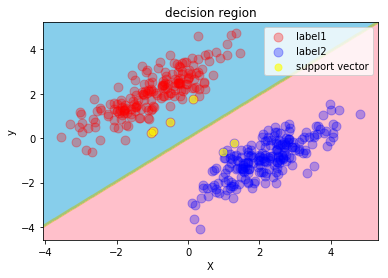

In [20]:
decision_region(X_train, y_train, clf, title='decision region', xlabel='X', ylabel='y', target_names=['label1', 'label2'])